In [47]:
import sys
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import re, os, time, sys, datetime, csv
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import xgboost.compat
import xgboost as xgb
import lightgbm as gbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV  

import sklearn.cross_validation
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.decomposition import PCA
import datetime
import cx_Oracle
import seaborn as sns
from matplotlib import pyplot as mplt
from sklearn import preprocessing
import re
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, \
                            roc_curve, precision_recall_curve, average_precision_score, f1_score, \
                            classification_report, average_precision_score, confusion_matrix 
from sklearn.preprocessing import normalize, binarize

from label_encoder import SoftLabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from support_library.plot import Plot as plt
from support_library.feature_eng import Featureng as fe

In [92]:
% matplotlib inline

In [48]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [49]:
def getboostparams(model_name, X_trn, y_trn, X_tst, y_tst):
    switcher={
        LGBMClassifier:
                        {'params': 
                                    {
                                        'n_estimators':10000, 
                                        'num_leaves':150, 
                                        'max_bin':100, 
                                        'bagging_fraction':0.8, 
                                        'bagging_freq':10, 
                                        'n_jobs':60, 
                                        'feature_fraction':0.5, 
                                        'lambda_l1':0, 
                                        'lambda_l2':1, 
                                        'min_child_weight':1e-05,
                                        'min_data_in_leaf':100, 
                                        'random_state':42
                                    },
                         'fit_params': 
                                    {
                                        'eval_set': [(X_trn, y_trn),
                                                     (X_tst, y_tst)], 
                                        'early_stopping_rounds': 15,
                                        'eval_metric': ['auc', 'logloss'], 
                                        'verbose': False
                                    }
                        },
        XGBClassifier:
                        {'params':        
                                    {
                                         'base_score': 0.5,
                                         'booster': 'gbtree',
                                         'colsample_bylevel': 1,
                                         'colsample_bytree': 0.6,
                                         'gamma': 5,
                                         'learning_rate': 0.1,
                                         'max_delta_step': 0,
                                         'max_depth': 10,
                                         'min_child_weight': 10,
                                         'missing': None,
                                         'n_estimators': 10000,
                                         'n_jobs': 60,
                                         'objective': 'binary:logistic',
                                         'random_state': 0,
                                         'reg_alpha': 0,
                                         'reg_lambda': 1,
                                         'scale_pos_weight': 1,
                                         'seed': 42,
                                         #'silent': True,
                                         'subsample': 1.0
                                    },
                         'fit_params': 
                                    {
                                        'eval_set': [(X_trn, y_trn),
                                                     (X_tst, y_tst)], 
                                        'early_stopping_rounds': 15,
                                        'eval_metric': ['auc', 'logloss'], 
                                        'verbose': False
                                    }                        
                        
                        },
        
        RandomForestClassifier:
                        {'params':           
                                    {
                                        'n_estimators': 10000, 
                                        'criterion': 'gini', 
                                        'max_depth': None, 
                                        'min_samples_split':2, 
                                        'min_samples_leaf':1, 
                                        'min_weight_fraction_leaf':0.0, 
                                        'max_features': 'auto', 
                                        'max_leaf_nodes': None, 
                                        'min_impurity_decrease': 0.0,
                                        'bootstrap': True, 
                                        'oob_score': False, 
                                        'n_jobs': 40, 
                                        'random_state': 32, 
                                        'verbose': 0
                                    },
                         'fit_params': {}
                        }
    }
    

    params     = switcher.get(model_name)['params']
    fit_params = switcher.get(model_name)['fit_params']
    
    return params, fit_params

In [50]:
def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print('AUC: %.5f, Precision: %.5f, Recall: %.5f, F1: %.5f \n' % (roc_auc_score(y_test, y_pred_proba), \
                                    precision_score(y_test, y_pred), recall_score(y_test, y_pred), 
                                                                     f1_score(y_test, y_pred)))
    print('Average precision: %.5f \n' % average_precision_score(y_test, y_pred_proba))
    print(classification_report(y_test, y_pred, digits=5))
    plt.confusion_matrix_heatmap(y_test, y_pred)

In [51]:
def eval_model(model, X, y, threshold=0.5):
    if model is XGBClassifier: 
        y_pred_proba = model.predict_proba(X, ntree_limit=model.best_ntree_limit)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
        
    y_pred = binarize(y_pred_proba.reshape(-1,1), threshold=threshold).reshape(-1).astype(int)
    #y_pred[X.cluster == 0] = 0

    TP = np.sum(np.logical_and(y_pred == 1, y == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y == 0))
    FP = np.sum(np.logical_and(y_pred == 1, y == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y == 1))
    
    print('-' * 68)
    if model is XGBClassifier:
        print('AUC:%.5f, Precision:%.5f, Recall:%.5f, Trees:%d, True:%d of %d, Total:%d, Tr:%.2f' %
              (roc_auc_score(y, y_pred_proba),
               precision_score(y, y_pred),
               recall_score(y, y_pred),
               model.best_ntree_limit, TP, TP+FP, TP+FN,
               threshold), flush=True)
    else:
         print('AUC:%.5f, Precision:%.5f, Recall:%.5f, True:%d of %d, Total:%d, Tr:%.2f' %
              (roc_auc_score(y, y_pred_proba),
               precision_score(y, y_pred),
               recall_score(y, y_pred), TP, TP+FP, TP+FN,
               threshold), flush=True)       
    print('-' * 68)
    
    return y_pred, y_pred_proba

In [52]:
def train_full(X_train, X_test, y_train, y_test, model_name, cat_features, 
               cattopoly, threshold=0.5, save_dict=False):
    
    X_trn, X_tst = fe.features_endineering( X_train, X_test, 
                                            y_train, 
                                            cat_features, 
                                            cattopoly, 
                                            save_dict=save_dict)
    
    params, fit_params = getboostparams(model_name, X_trn, y_train, X_tst, y_test)
    model=model_name(**params)
    model.fit( X_trn, y_train, **fit_params )
        
    joblib.dump(model, get_path('pkl_store', model_name.__name__ + '_f.pkl'), compress=9)
    
    y_val, y_val_proba = eval_model(model, X_tst, y_test, threshold=threshold)

    plt.auc_curve(y_test, y_val_proba)
    plt.precision_recall_threshold_curve(y_test, y_val_proba)
    plt.precision_recall_curve(y_test, y_val_proba)
    plt.distplot(y_val_proba)
    plt.feature_impotance(model, X_trn, count_top_features = 20)  
    

    return y_val, y_val_proba

In [53]:
def train(X, y, columns, model_name, cat_features, cattopoly, n_folds=4, 
          log=True, threshold=0.5, save_dict=False):

    blend_train       = np.zeros(X.shape[0])
    blend_train_proba = np.zeros(X.shape[0])

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        X_trn, X_tst = X.iloc[train_index], X.iloc[test_index]
        y_trn, y_tst = y.iloc[train_index], y.iloc[test_index]
        
        X_trn, X_tst = fe.features_endineering(X_trn, X_tst, y_trn, 
                                                  cat_features, cattopoly, 
                                                  save_dict=save_dict)
             
        params, fit_params = getboostparams(model_name, X_trn, y_trn, X_tst, y_tst)
        model=model_name(**params)
        model.fit( X_trn, y_trn, **fit_params )          

        blend_train[test_index], blend_train_proba[test_index] = eval_model(model, X_tst, y_tst, 
                                                                            threshold=threshold)
        #joblib.dump(model, model_name, compress=9)
        
    if log: 
        print('-' * 68)
        #calculate metrics over whole dataset:
        TP = np.sum(np.logical_and(blend_train == 1, y == 1))
        TN = np.sum(np.logical_and(blend_train == 0, y == 0))
        FP = np.sum(np.logical_and(blend_train == 1, y == 0))
        FN = np.sum(np.logical_and(blend_train == 0, y == 1))

        print('AUC: %7.5f, Precision: %7.5f, Recall: %7.5f, True:%d of %d, Total:%d' %
              (roc_auc_score(y, blend_train_proba),
               precision_score(y, blend_train),
               recall_score(y, blend_train),
               TP, TP+FP, TP+FN), flush=True)

        print('f1_score: %.5f \n' % f1_score(y, blend_train))
        print('Average precision: %.5f \n' % average_precision_score(y, blend_train_proba))

        plt.auc_curve(y, blend_train_proba)
        plt.precision_recall_threshold_curve(y, blend_train_proba)
        plt.feature_impotance(model, X, count_top_features = 20)
    
    return blend_train, blend_train_proba

In [54]:
df = pd.read_pickle('pkl_store/total_dataset_unencoded.pkl')

In [55]:
df.reset_index(inplace=True,drop=1)
df

,is_sold,tb,gosb,product,product_group,days_cr_q_end,segment_client,priority_client,sum_sold,sum_sold_cumulate,...,cash_management_ratio_share_prod_shift_3,overdraft_kredit_ratio_share_prod_shift_3,corporate_cards_ratio_share_prod_shift_3,spec_acc_ratio_share_prod_shift_3,samoinkass_ratio_share_prod_shift_3,obsluzh_rts_rur_ratio_share_prod_shift_3,days_between,is_previous_sold,days_between_km_dealdiff,is_previous_sold_km_dealdiff
0,1,Волго-Вятский банк,Банк Татарстан ГОСБ №8610,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,34,Микро,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Московский банк,Московский банк,Неснижаемый остаток,ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,34,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Московский банк,Московский банк,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Сибирский банк,Красноярское ГОСБ №8646,Зарплатные проекты,ЗАРПЛАТНЫЕ ПРОЕКТЫ,32,Микро,Нет,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Центрально-Черноземный банк,ГО по Воронежской области,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Микро,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,Сибирский банк,Новосибирское ГОСБ №8047,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,Сибирский банк,Абаканское ГОСБ №8602,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,Сибирский банк,Новосибирское ГОСБ №8047,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,Московский банк,Московский банк,Зарплатные проекты,ЗАРПЛАТНЫЕ ПРОЕКТЫ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,Уральский банк,Челябинское ГОСБ №8597,Неснижаемый остаток,ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Малые,Ключевой,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
top_corr_features = pd.read_pickle('pkl_store/top_corr_features_le_all.pkl')

In [58]:
le=joblib.load(get_path('pkl_store', 'label_encoders_trn.pkl'))
cat_features=list(set(le.keys()))
cat_features

['gosb', 'segment_client', 'priority_client', 'product', 'product_group', 'tb']

In [59]:
# define base features to calculate polynomial features interactions 
cattopoly=[ 'product_avg_mean',
            'product_avg_std',
            'product_group_avg_mean',
            'product_group_avg_std',
            'gosb_avg_mean',
            'gosb_avg_std',
            'tb_avg_mean',
            'tb_avg_std',
            'priority_client_avg_mean',
            'priority_client_avg_std',
            'days_between_km_dealdiff',
            'sum_sold_total_cumulate_km_shift_3'
] 

In [60]:
balance = pd.concat([df.groupby('product_group')['is_sold'].sum(), 
                     df.groupby('product_group')['is_sold'].count()], axis=1)
balance.columns = ['Sum of sold', 'Count']
balance['balance'] = balance['Sum of sold'] / balance['Count']
balance = balance.sort_values('balance', ascending=False)
balance

,Sum of sold,Count,balance
product_group,,,
АРЕНДА СЕЙФОВ,1,1,1.000000
РОЗНИЧНЫЕ ПРОДУКТЫ,2,2,1.000000
СПЕЦ СЧЕТ ДЛЯ ТОРГОВ,3,3,1.000000
ВЕКСЕЛЯ,98,100,0.980000
ИНФОРМАЦИОННЫЕ УСЛУГИ,20790,21375,0.972632
РКО,76388,79676,0.958733
ИНКАССАЦИЯ,28442,29741,0.956323
ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,43806,47102,0.930024
ПАКЕТЫ УСЛУГ,36539,39663,0.921236


In [61]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['is_sold', 'days_cr_q_end'], dtype='object'),
 dtype('float64'): Index(['sum_sold', 'sum_sold_cumulate', 'sum_refused', 'sum_refused_cumulate',
        'sum_sold_total', 'sum_sold_total_cumulate', 'sum_refused_total',
        'sum_refused_tota_cumulate', 'sum_sold_company_shift_1',
        'sum_sold_cumulate_company_shift_1',
        ...
        'cash_management_ratio_share_prod_shift_3',
        'overdraft_kredit_ratio_share_prod_shift_3',
        'corporate_cards_ratio_share_prod_shift_3',
        'spec_acc_ratio_share_prod_shift_3',
        'samoinkass_ratio_share_prod_shift_3',
        'obsluzh_rts_rur_ratio_share_prod_shift_3', 'days_between',
        'is_previous_sold', 'days_between_km_dealdiff',
        'is_previous_sold_km_dealdiff'],
       dtype='object', length=261),
 dtype('O'): Index(['tb', 'gosb', 'product', 'product_group', 'segment_client',
        'priority_client'],
       dtype='object')}

In [62]:
dd=df.groupby('product_group')[['is_sold','days_between']].sum()
dd.loc[:,['is_sold','days_between']]

,is_sold,days_between
product_group,,
CASH MANAGEMENT,8,2863.0
АРЕНДА СЕЙФОВ,1,0.0
БАНКОВСКАЯ ГАРАНТИЯ,3254,103651.0
БИЗНЕС-КАРТА,39063,343725.0
ВАЛЮТНЫЙ КОНТРОЛЬ,287,5044.0
ВЕКСЕЛЯ,98,586.0
ВНЕШНИЙ МАЛЫЙ СМАРТ,9,497.0
ВНЕШНИЙ МИКРО СМАРТ,50,1309.0
ДЕЛОВАЯ СРЕДА,286,2136.0


In [63]:
product_groups_without_balance = list(balance[(balance['balance'] == 1) | (balance['balance'] == 0)].index)

In [64]:
df = df[~df['product_group'].isin(product_groups_without_balance)]

In [65]:
unique_counts = pd.DataFrame()
for col in df.columns:
    unique_counts = unique_counts.append([[col, len(df[col].unique())]])
unique_counts.columns = ['colname', 'unique_counts']
unique_counts.head()

,colname,unique_counts
0,is_sold,2
0,tb,14
0,gosb,90
0,product,135
0,product_group,28


In [66]:
non_unique_columns = unique_counts[unique_counts['unique_counts'] == 1]['colname'].values
non_unique_columns

array([], dtype=object)

In [67]:
target_column = 'is_sold'
#drop_columns = ['ckp']
#X, y = df.drop(target_column, axis = 1).drop(drop_columns, 1), df[target_column]
X, y = df.drop(non_unique_columns, axis = 1).drop(target_column, axis = 1), df[target_column]

In [68]:
X=X[top_corr_features]
X.head()

,product,product_group,days_cr_q_end,gosb,tb,days_between,priority_client,days_between_km_dealdiff,sum_sold_total_cumulate_km_shift_3,sum_sold_cumulate_agg_km_shift_1,...,ns_terminal_ratio_share_prod_shift_2,bank_straxovanie_lich_share_prod_shift_2,bank_straxovanie_lich_share_prod_shift_3,deposit_share_prod_shift_3,deposit_share_prod_shift_2,sum_sold_agg_company_shift_1,spec_acc,segment_client,invest_kredit,inkass
0,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,34,Банк Татарстан ГОСБ №8610,Волго-Вятский банк,NaN,Ключевой,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Микро,NaN,NaN
1,Неснижаемый остаток,ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,34,Московский банк,Московский банк,NaN,Ключевой,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Малые,NaN,NaN
2,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,Московский банк,Московский банк,NaN,Ключевой,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Малые,NaN,NaN
3,Зарплатные проекты,ЗАРПЛАТНЫЕ ПРОЕКТЫ,32,Красноярское ГОСБ №8646,Сибирский банк,NaN,Нет,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Микро,NaN,NaN
4,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,32,ГО по Воронежской области,Центрально-Черноземный банк,NaN,Ключевой,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Микро,NaN,NaN


In [69]:
df1=df.groupby('product_group')['is_sold'].transform(lambda x: np.log((x.count()-x.sum())/x.count()))

In [70]:
df.groupby('product_group')['is_sold'].agg([('sum',lambda x: x.sum()),('count', lambda x: x.count()),
                                            ('ratio_1', lambda x: x.sum()/x.count()),
                                            ('ratio_0', lambda x: (x.count()-x.sum())/x.count())]).reset_index()

,product_group,sum,count,ratio_1,ratio_0
0,CASH MANAGEMENT,8,53,0.150943,0.849057
1,БАНКОВСКАЯ ГАРАНТИЯ,3254,5105,0.637414,0.362586
2,БИЗНЕС-КАРТА,39063,56386,0.692778,0.307222
3,ВАЛЮТНЫЙ КОНТРОЛЬ,287,344,0.834302,0.165698
4,ВЕКСЕЛЯ,98,100,0.980000,0.020000
5,ВНЕШНИЙ МАЛЫЙ СМАРТ,9,19,0.473684,0.526316
6,ВНЕШНИЙ МИКРО СМАРТ,50,92,0.543478,0.456522
7,ДЕЛОВАЯ СРЕДА,286,336,0.851190,0.148810
8,ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ,59,67,0.880597,0.119403
9,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,2771,8664,0.319829,0.680171


## Boosting Aggregation

In [71]:
X_test, X_train, y_test, y_train = train_test_split(X, y, shuffle=False, test_size=0.70, random_state=42)

In [72]:
null_compare = pd.DataFrame(X_train.isnull().sum(), columns=['train_null_count'])
null_compare['train_null_ratio'] = null_compare['train_null_count'] / X_train.shape[0] * 100
null_compare = null_compare.join(X_test.isnull().sum().rename('test_null_count'))
null_compare['test_null_ratio'] = null_compare['test_null_count'] / X_test.shape[0] * 100
null_compare['diff_abs'] = np.abs(null_compare['train_null_ratio'] - null_compare['test_null_ratio'])
null_compare.sort_values('diff_abs', ascending=False)

,train_null_count,train_null_ratio,test_null_count,test_null_ratio,diff_abs
invest_kredit_ratio_share_prod_shift_3,108782,34.883803,121528,90.933443,56.049640
invest_kredit_ratio_share_prod_shift_2,95870,30.743231,115630,86.520259,55.777028
sum_refused_tota_cumulate_agg_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_refused_cumulate_agg_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_cumulate_agg_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_total_cumulate_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_total_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_refused_tota_cumulate_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_cumulate_km_shift_3,14,0.004489,63025,47.158517,47.154027
sum_sold_total_cumulate_agg_km_shift_3,14,0.004489,63025,47.158517,47.154027


In [73]:
X_train_meta=X_train.copy()
X_test_meta=X_test.copy()

In [74]:
X_train_meta.shape

(311841, 158)

## Specify a list of estimators to fit the base model

In [75]:
#cls={RandomForestClassifier: 'randomf', LGBMClassifier: 'lightgbm', XGBClassifier: 'xgboost'}
cls={LGBMClassifier: 'lightgbm', XGBClassifier: 'xgboost'}

## Fit the base model to each training fold

<class 'lightgbm.sklearn.LGBMClassifier'>
--------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Специализированные продукты для малого бизнеса - корпоративное кредитование, Доставка денежной наличности и ценностей, Гарантия - обязательства по договору (Унифицированный), Векселя, ПУ Зарплатный
New labels:  ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ
New labels:  NaN
New labels:  NaN
--------------------------------------------------------------------
AUC:0.88697, Precision:0.86456, Recall:0.92640, True:72699 of 84088, Total:78475, Tr:0.50
--------------------------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Инвестиционное кредитование (кроме строит-ва) (Структурированный), Индивидуальный овердрафт, Контрактное кредитование подрядчиков
New labels:  NaN
New labels:  NaN
--------------------------------------------------------------------
AUC:0.88536, Precision:0.86362, Recall:0.92642, True:72701 of 84182, Total:78475, Tr:0.50
--------------------------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Тендерная гарантия (Структурированный), Продвижение бизнеса онлайн, Кредитование внешнеторговых контрактов, Кредитование под залог коммерческой недвижимости, Расчетные векселя
New labels:  NaN
New labels:  NaN
New labels:  B
--------------------------------------------------------------------
AUC:0.88525, Precision:0.86402, Recall:0.92651, True:72707 of 84150, Total:78474, Tr:0.50
--------------------------------------------------------------------
--------------------------------------------------------------------
AUC: 0.88584, Precision: 0.86406, Recall: 0.92644, True:218107 of 252420, Total:235424
f1_score: 0.89417 

Average precision: 0.95952 



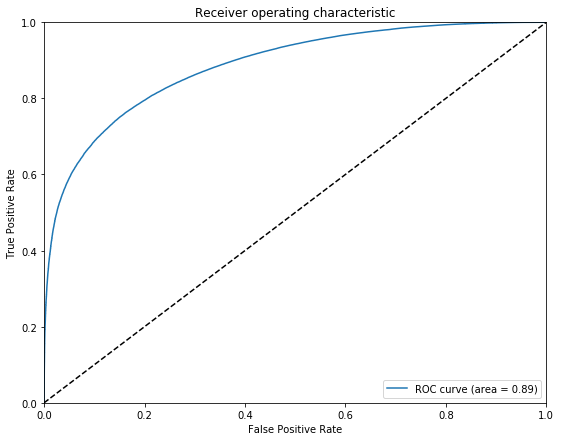

/home/ektov-av/notebooks/myscripts/support_library/plot.py:129: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


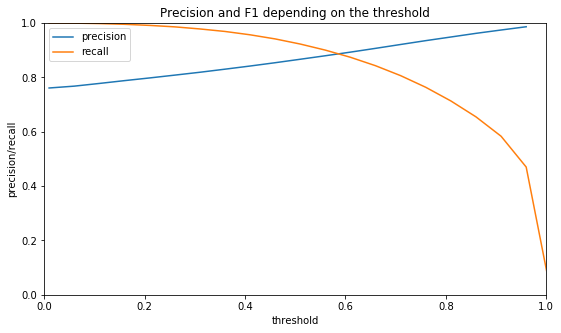

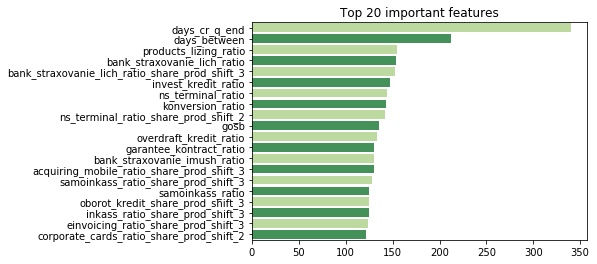

<class 'xgboost.sklearn.XGBClassifier'>
--------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Специализированные продукты для малого бизнеса - корпоративное кредитование, Доставка денежной наличности и ценностей, Гарантия - обязательства по договору (Унифицированный), Векселя, ПУ Зарплатный
New labels:  ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ
New labels:  NaN
New labels:  NaN
--------------------------------------------------------------------
AUC:0.88632, Precision:0.86267, Recall:0.92830, True:72848 of 84445, Total:78475, Tr:0.50
--------------------------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Инвестиционное кредитование (кроме строит-ва) (Структурированный), Индивидуальный овердрафт, Контрактное кредитование подрядчиков
New labels:  NaN
New labels:  NaN
--------------------------------------------------------------------
AUC:0.88465, Precision:0.86192, Recall:0.93011, True:72990 of 84683, Total:78475, Tr:0.50
--------------------------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  Тендерная гарантия (Структурированный), Продвижение бизнеса онлайн, Кредитование внешнеторговых контрактов, Кредитование под залог коммерческой недвижимости, Расчетные векселя
New labels:  NaN
New labels:  NaN
New labels:  B
--------------------------------------------------------------------
AUC:0.88503, Precision:0.86320, Recall:0.92794, True:72819 of 84359, Total:78474, Tr:0.50
--------------------------------------------------------------------
--------------------------------------------------------------------
AUC: 0.88532, Precision: 0.86260, Recall: 0.92878, True:218657 of 253487, Total:235424
f1_score: 0.89447 

Average precision: 0.95921 



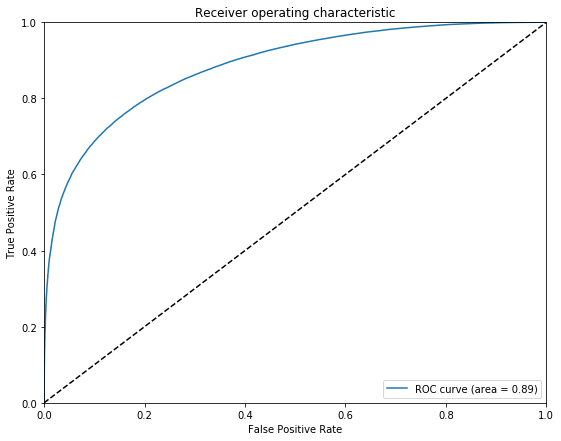

/home/ektov-av/notebooks/myscripts/support_library/plot.py:129: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


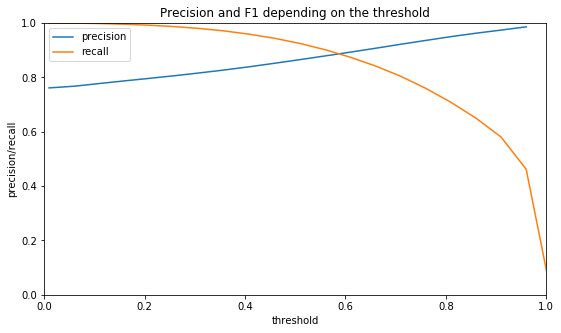

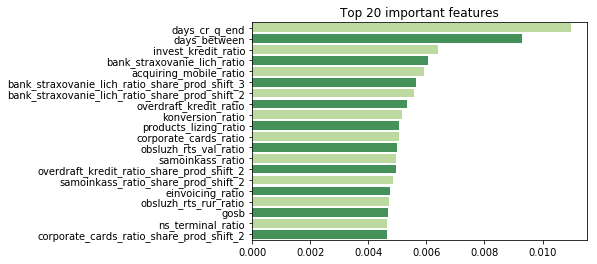

In [76]:
## For each base model
# Fit the base model to the training fold and make predictions on the test fold
# Store tese predictions in X_train_meta to be used as features for the stacking model
for model in list(cls.keys()):
    print(model)
    print('-'*50)
    blend_train, blend_train_proba = train(
                                               X_train, y_train, 
                                               columns=X.columns, 
                                               model_name=model, 
                                               cattopoly=cattopoly,
                                               cat_features=cat_features,
                                               n_folds=3, 
                                               log=True,
                                               threshold=0.5,
                                               save_dict= False
                                          )
    X_train_meta=X_train_meta.join(pd.DataFrame(pd.Series(blend_train, name=cls[model], index=X_train_meta.index)))

In [77]:
joblib.dump(X_train_meta, get_path('pkl_store', 'X_train_meta.pkl'))   

['pkl_store/X_train_meta.pkl']

## Fit the base model to the full training dataset (No Cross-Folding)

<class 'lightgbm.sklearn.LGBMClassifier'>
--------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  РКО, лизинг конвейер, GM. DCD, Еженедельник руководителя, Обезличенные метал. счета, Индивидуальный овердрафт-Прото, Кредитование субъектов РФ и муниципальных образований, Сервис проверки контрагентов, GM. FWD, Контрактное кредитование ЮЛ и ИП, Гарантии/контргарантии договорная (возврата аванса), Корпоративное кредитование (Структурированный), Прием по объявлению на взнос, Лизинг Фабрика, GM. SYNTHETIC DEPO, Системы ДБО, отличные от СББОЛ/СББ, ПУ Оптима, ПУ Торговый плюс, АС Voice-Информатор, Финансирование строительства объектов жилой недвижимости, ПУ Актив, ПУ Минимальный, Гарантия в пользу налоговых органов, ПФ  (кроме строительства и иных проектов, относящихся к компетенции УФН), ПУ Безналичный, GM. FX, ПУ Базис
New labels:  ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ
New labels:  NaN
New labels:  NaN
New labels:  A2, A, D2
--------------------------------------------------------------------
AUC:0.85123, Precision:0.82889, Recall:0.92010, True:89807 of 108346, Total:97606, Tr:0.50
-------

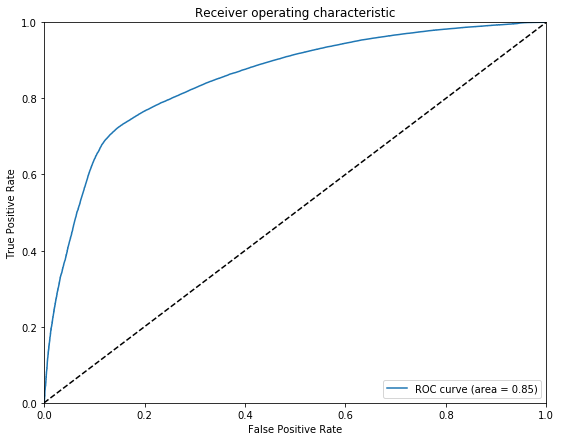

/home/ektov-av/notebooks/myscripts/support_library/plot.py:129: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


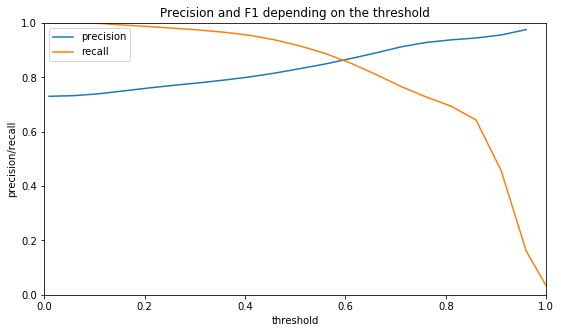

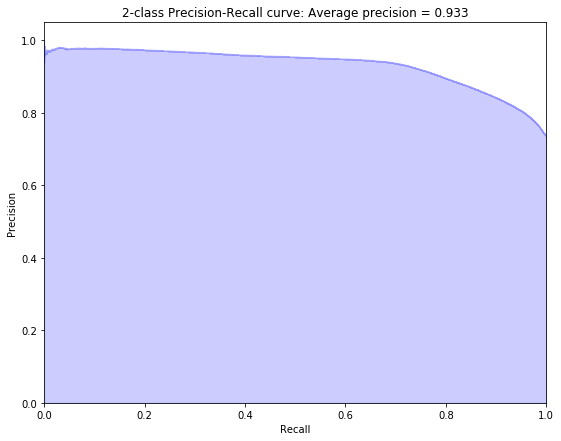

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


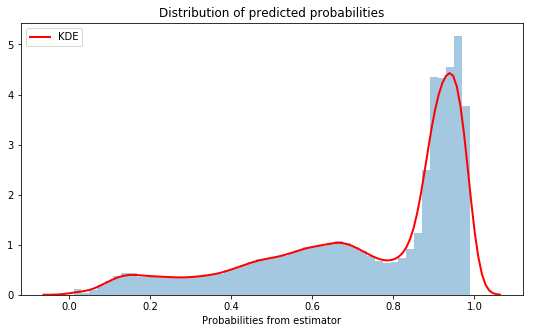

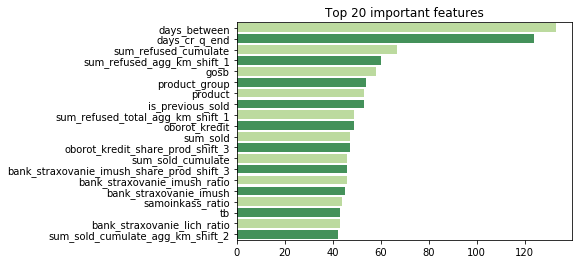

<class 'xgboost.sklearn.XGBClassifier'>
--------------------------------------------------


/home/ektov-av/notebooks/myscripts/support_library/feature_eng.py:203: RuntimeWarning: divide by zero encountered in log
  temp['WoE']=np.log(temp['ratio_1'] / temp['ratio_0'])


New labels:  РКО, лизинг конвейер, GM. DCD, Еженедельник руководителя, Обезличенные метал. счета, Индивидуальный овердрафт-Прото, Кредитование субъектов РФ и муниципальных образований, Сервис проверки контрагентов, GM. FWD, Контрактное кредитование ЮЛ и ИП, Гарантии/контргарантии договорная (возврата аванса), Корпоративное кредитование (Структурированный), Прием по объявлению на взнос, Лизинг Фабрика, GM. SYNTHETIC DEPO, Системы ДБО, отличные от СББОЛ/СББ, ПУ Оптима, ПУ Торговый плюс, АС Voice-Информатор, Финансирование строительства объектов жилой недвижимости, ПУ Актив, ПУ Минимальный, Гарантия в пользу налоговых органов, ПФ  (кроме строительства и иных проектов, относящихся к компетенции УФН), ПУ Безналичный, GM. FX, ПУ Базис
New labels:  ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ
New labels:  NaN
New labels:  NaN
New labels:  A2, A, D2
--------------------------------------------------------------------
AUC:0.84701, Precision:0.83007, Recall:0.91642, True:89448 of 107759, Total:97606, Tr:0.50
-------

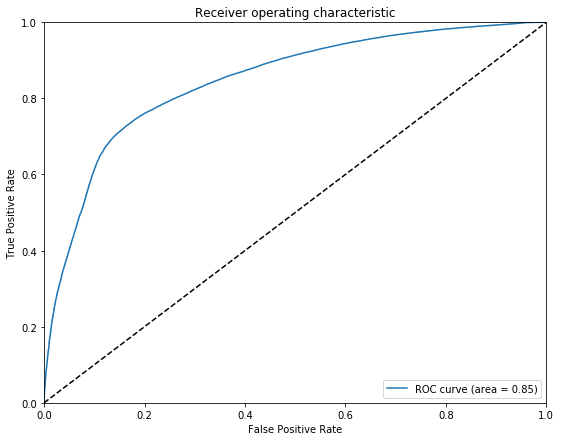

/home/ektov-av/notebooks/myscripts/support_library/plot.py:129: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


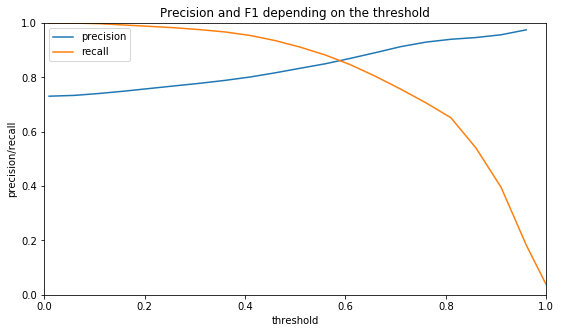

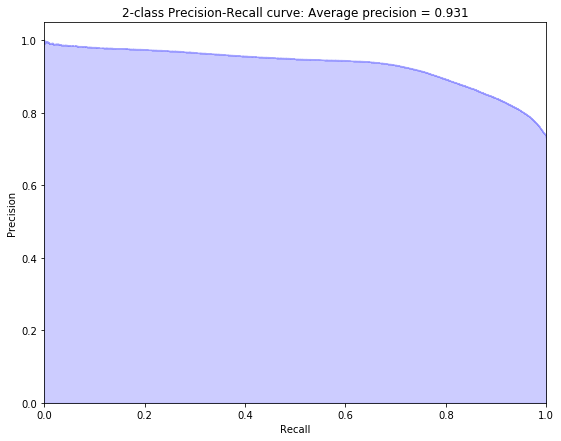

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


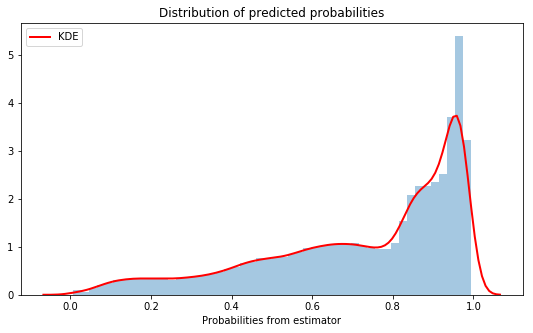

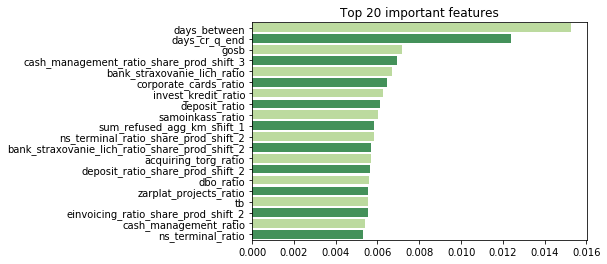

In [78]:
# Fit the base model to the full training dataset and make predictions on the test dataset
# Store tese predictions inside X_test_meta
for model in list(cls.keys()):
    print(model)
    print('-'*50)    
    y_tst, y_tst_proba = train_full(
                                        X_train, X_test, 
                                        y_train, y_test, 
                                        model_name=model, 
                                        cattopoly=cattopoly, 
                                        cat_features=cat_features, 
                                        threshold=0.5,
                                        save_dict= True
                                    )

    
    X_test_meta=X_test_meta.join(pd.DataFrame(pd.Series(y_tst, name=cls[model], index=X_test_meta.index)))

In [79]:
joblib.dump(X_test_meta, get_path('pkl_store', 'X_test_meta.pkl'))

['pkl_store/X_test_meta.pkl']

# Stacking

In [83]:
X_train_meta=joblib.load(get_path('pkl_store', 'X_train_meta.pkl'))
X_test_meta=joblib.load(get_path('pkl_store', 'X_test_meta.pkl'))

In [84]:
# Perform features engineering over X_train_meta, X_test_meta
X_train_meta = fe.features_enc_from_dict(X_train_meta, cat_features, cattopoly)
X_test_meta  = fe.features_enc_from_dict(X_test_meta, cat_features, cattopoly)

## LogisticRegression with CV

In [23]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline, make_union, Pipeline

In [76]:
imp=Imputer(missing_values=np.nan, strategy='median', axis=1)

In [82]:
temp=trn.loc[:,~trn.columns.isin(cat_features)]

In [54]:
# Initialize LogisticRegression with CV
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf=LogisticRegressionCV (Cs=4, fit_intercept=True, cv=2, dual=False, penalty='l2', scoring='roc_auc', \
                          solver='sag', max_iter=7000, class_weight='balanced', \
                          n_jobs=20, verbose=1, refit=True, intercept_scaling=1.0, \
                          multi_class='ovr', random_state=32)

In [55]:
estimator = Pipeline([('imp', Imputer(missing_values=np.nan, strategy='median', axis=0)), 
                      ('logreg', clf)])
# estimator= make_pipeline( Imputer(missing_values=np.nan, strategy='median', axis=1),
#                           LogisticRegressionCV (  Cs=4, fit_intercept=True, cv=3, dual=False, penalty='l2', \
#                                                   scoring='roc_auc', solver='sag', max_iter=8000, class_weight='balanced', \
#                                                   n_jobs=80, verbose=1, refit=True, intercept_scaling=1.0, \
#                                                   multi_class='ovr', random_state=32))

In [56]:
%%time
# with imputer
#clf.fit(imp.fit_transform(X_train_meta_enc), y_train)
estimator.fit(X_train_meta, y_train)

KeyboardInterrupt: 

In [25]:
joblib.dump(clf, 'pkl_store/LogisticRegressionCV.pkl')

['pkl_store/LogisticRegressionCV.pkl']

AUC: 0.84744, Precision: 0.91485, Recall: 0.74540, F1: 0.82147 

Average precision: 0.93290 

             precision    recall  f1-score   support

          0    0.52439   0.80182   0.63409     59300
          1    0.91485   0.74540   0.82147    169382

avg / total    0.81360   0.76003   0.77288    228682



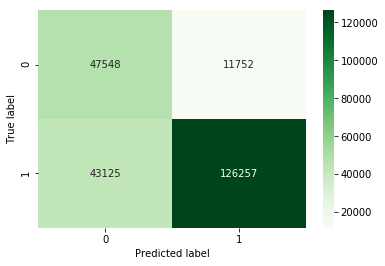

In [34]:
predict(clf, X_test_meta, y_test)

## XGboost

In [86]:
params, fit_params = getboostparams(XGBClassifier, 
                                    X_train_meta, y_train, 
                                    X_test_meta, y_test)
xgb = XGBClassifier(**params)

In [87]:
%%time
xgb.fit(X_train_meta, y_train, **fit_params)

CPU times: user 23min 52s, sys: 37.1 s, total: 24min 29s
Wall time: 42.8 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=10000,
       n_jobs=60, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1.0)

In [88]:
joblib.dump(xgb, get_path('pkl_store', XGBClassifier.__name__ + '_stack.pkl'), compress=9)

['pkl_store/XGBClassifier_stack.pkl']

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC: 0.84653, Precision: 0.82855, Recall: 0.92124, F1: 0.87244 

Average precision: 0.93152 

             precision    recall  f1-score   support

          0    0.69398   0.48370   0.57006     36039
          1    0.82855   0.92124   0.87244     97606

avg / total    0.79226   0.80325   0.79090    133645



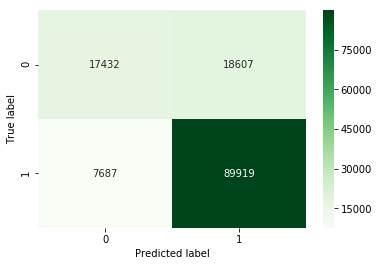

In [89]:
predict(xgb, X_test_meta, y_test)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


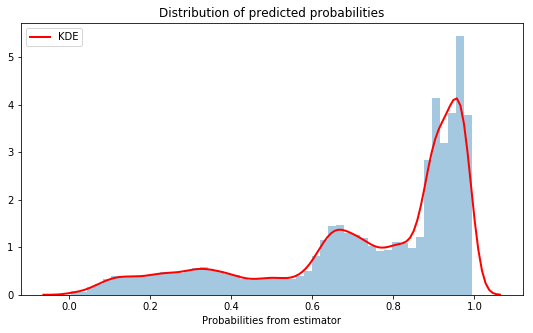

In [91]:
plt.distplot(xgb.predict_proba(X_test_meta)[:,1])

## LightGBM

In [93]:
params, fit_params = getboostparams(LGBMClassifier, 
                                    X_train_meta, y_train, 
                                    X_test_meta, y_test)
gbm = LGBMClassifier(**params)

In [94]:
%%time
gbm.fit(X_train_meta, y_train, **fit_params)

CPU times: user 7min 39s, sys: 6.54 s, total: 7min 45s
Wall time: 20.2 s


LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting_type='gbdt',
        colsample_bytree=1.0, feature_fraction=0.5, lambda_l1=0,
        lambda_l2=1, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=1e-05, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=10000, n_jobs=60, num_leaves=150,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [95]:
joblib.dump(gbm, get_path('pkl_store', LGBMClassifier.__name__ + '_stack.pkl'), compress=9)

['pkl_store/LGBMClassifier_stack.pkl']

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC: 0.85239, Precision: 0.82822, Recall: 0.92211, F1: 0.87265 

Average precision: 0.93422 

             precision    recall  f1-score   support

          0    0.69558   0.48203   0.56944     36039
          1    0.82822   0.92211   0.87265     97606

avg / total    0.79245   0.80343   0.79088    133645



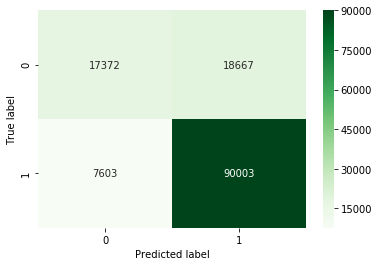

In [96]:
predict(gbm, X_test_meta, y_test)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


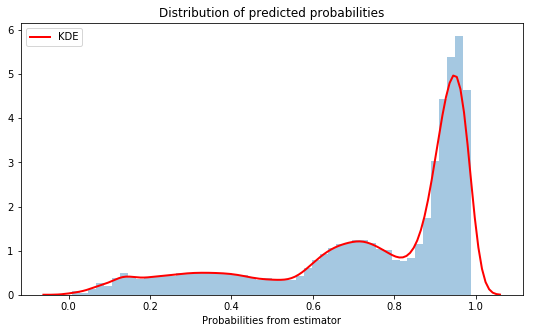

In [97]:
plt.distplot(gbm.predict_proba(X_test_meta)[:,1])

## Compare metric between product's groups

In [136]:
le_dict              = joblib.load(get_path('pkl_store', 'le_dict.pkl'))['product_group']
product_group_lables = pd.DataFrame({'label': list(le_dict.get_keys()), 'value': list(le_dict.get_labels())})
product_group_lables = product_group_lables.set_index('value')

In [65]:
product_group_lables

,label
value,
15,КОНВЕРСИОННЫЕ ОПЕРАЦИИ
11,ЗАРПЛАТНЫЕ ПРОЕКТЫ
20,ПРИЕМ ПЛАТЕЖЕЙ ФИЗ. ЛИЦ
12,ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ
7,ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ
24,ТЕХНИЧЕСКИЕ ПРОДУКТЫ
19,ПРЕМИАЛЬНАЯ БИЗНЕС-КАРТА
16,КРЕДИТНАЯ БИЗНЕС-КАРТА
17,КРЕДИТОВАНИЕ


In [138]:
xgb = joblib.load(get_path('pkl_store', XGBClassifier.__name__ + '_stack.pkl'))

In [139]:
y_pred= xgb.predict(X_test_meta)
y_pred_proba= xgb.predict_proba(X_test_meta)

y_df_pred  = pd.Series(index=X_test_meta.index)
y_df_proba = pd.Series(index=X_test_meta.index)

y_df_pred.loc[X_test_meta.index] = y_pred
y_df_proba.loc[X_test_meta.index] = y_pred_proba[:, 1]

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [140]:
col_name = 'product_group'
scores_by_product_groups = pd.DataFrame(columns=[col_name, 'accuracy', 'precision', 'recall'])
for val in product_group_lables.index:
    indexes = X_test_meta[X_test_meta[col_name] == val].index
    scores_by_product_groups = scores_by_product_groups.append({col_name: product_group_lables.loc[val]['label'], \
                                     'accuracy': accuracy_score(y_test.loc[indexes], y_df_pred.loc[indexes]), \
                                     'precision': precision_score(y_test.loc[indexes], y_df_pred.loc[indexes]), \
                                     'recall': recall_score(y_test.loc[indexes], y_df_pred.loc[indexes])
                                                               }, ignore_index=True)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ektov-av/python35-libs/lib/python3.5/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/ektov-av/python35-libs/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [141]:
scores_by_product_groups.sort_values('accuracy', ascending=False, inplace=True)

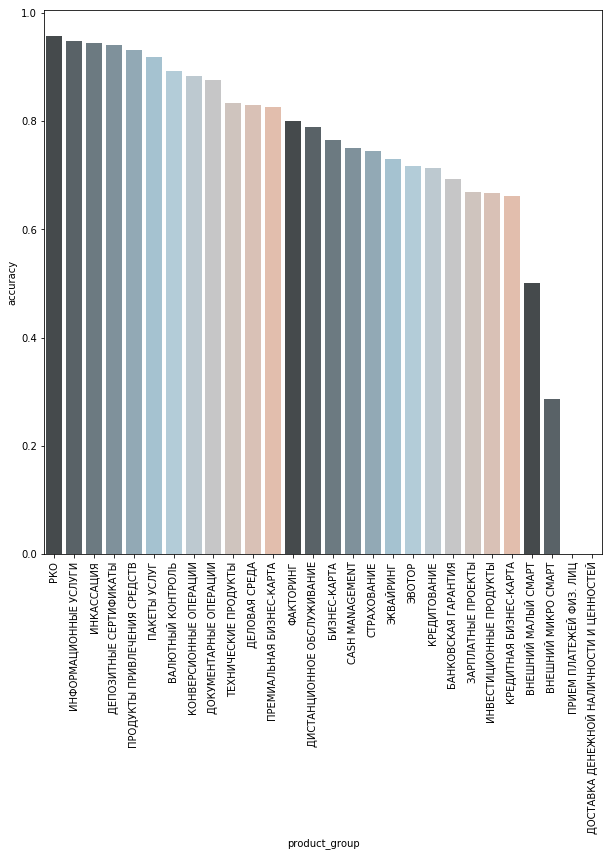

In [170]:
mplt.subplots(figsize=(10, 10))
fig = sns.barplot(x=scores_by_product_groups[col_name], y=scores_by_product_groups['accuracy'], 
                  palette=sns.color_palette('RdBu_d',12))
_, labels = mplt.xticks()
fig.set_xticklabels(labels, rotation=90)
# fig.set(ylabel=y_label, title=title)
mplt.show()

## Make prediction on a new validation dataset

In [98]:
df_tst = pd.read_pickle('pkl_store/test_dataset_unencoded.pkl')

In [99]:
X_val=df_tst.loc[:,top_corr_features]
X_val_meta=X_val.copy()

In [100]:
le_dict     = joblib.load(get_path('pkl_store', 'le_dict.pkl'))
for col in cat_features:
    ss=set(X_val[col])-set(le_dict[col].get_keys())
    print(list(ss))

[nan, nan, nan, nan]
[]
[]
['Факторинг', 'Гарантии исполнения финансовых обязательств по кредитному договору', 'Спец счет для торгов', 'GM. FX OPTION']
['СПЕЦ СЧЕТ ДЛЯ ТОРГОВ', 'ФАКТОРИНГ']
[nan]


In [101]:
X_val_enc = fe.features_enc_from_dict(X_val, cat_features, cattopoly)

New labels:  Факторинг, Гарантии исполнения финансовых обязательств по кредитному договору, Спец счет для торгов, GM. FX OPTION
New labels:  СПЕЦ СЧЕТ ДЛЯ ТОРГОВ, ФАКТОРИНГ


In [102]:
cls={LGBMClassifier: 'lightgbm', XGBClassifier: 'xgboost'}

In [103]:
## For each base model
# Fit the base model to the training fold and make predictions on the test fold
# Store tese predictions in X_train_meta to be used as features for the stacking model
for model in list(cls.keys()):
    print(model.__name__)
    cl=joblib.load(get_path('pkl_store', model.__name__+'_f.pkl'))
    y_val_pred=cl.predict(X_val_enc)
    X_val_meta=X_val_meta.join(pd.DataFrame(pd.Series(y_val_pred, name=cls[model], index=X_val_meta.index)))

LGBMClassifier


/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier


/home/ektov-av/python35-libs/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [104]:
X_val_meta = fe.features_enc_from_dict(X_val_meta, cat_features, cattopoly)

New labels:  Факторинг, Гарантии исполнения финансовых обязательств по кредитному договору, Спец счет для торгов, GM. FX OPTION
New labels:  СПЕЦ СЧЕТ ДЛЯ ТОРГОВ, ФАКТОРИНГ


In [105]:
count=0
y_avr_proba=[]
for model in list(cls.keys()):
    count=count+1
    print(model.__name__)
    cl=joblib.load(get_path('pkl_store', model.__name__+'_stack.pkl'))
    y_val_proba = cl.predict_proba(X_val_meta)
    print(len(y_val_proba))
    if count != len(cls):
        temp=y_val_proba
    else:
        y_avr_proba = (temp+y_val_proba)*0.5

LGBMClassifier
19860
XGBClassifier
19860


In [107]:
y_pred = binarize(y_avr_proba[:,1].reshape(-1,1), threshold=0.5).reshape(-1).astype(int)

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


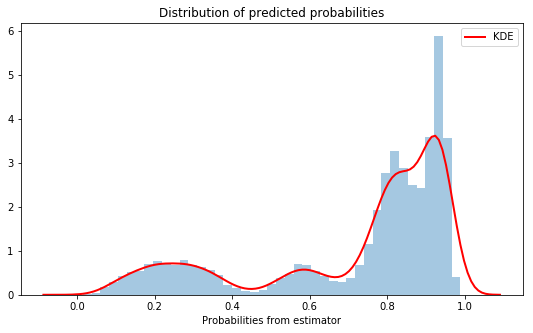

In [106]:
plt.distplot(y_avr_proba[:,1])

/home/ektov-av/python35-libs/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


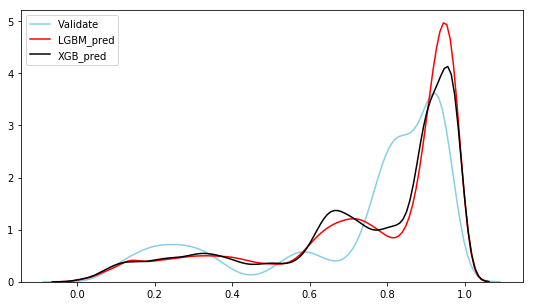

In [108]:
fig = mplt.figure(figsize=(9,5))
sns.distplot(y_avr_proba[:,1], label='Validate', color='skyblue', hist=False)
sns.distplot(gbm.predict_proba(X_test_meta)[:,1], label='LGBM_pred', color='red', hist=False)
sns.distplot(xgb.predict_proba(X_test_meta)[:,1], label='XGB_pred', color='black', hist=False)

## Classification Probability Calibration 

In [131]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, 

In [132]:
X_train_meta=joblib.load(get_path('pkl_store', 'X_train_meta.pkl'))
X_test_meta=joblib.load(get_path('pkl_store', 'X_test_meta.pkl'))

In [133]:
# Perform features engineering over X_train_meta, X_test_meta
X_train_meta = fe.features_enc_from_dict(X_train_meta, cat_features, cattopoly)
X_test_meta  = fe.features_enc_from_dict(X_test_meta, cat_features, cattopoly)

In [135]:
model=LGBMClassifier
cl=joblib.load(get_path('pkl_store', model.__name__+'_stack.pkl'))
y_tst_proba = cl.predict_proba(X_test_meta)[:,1]

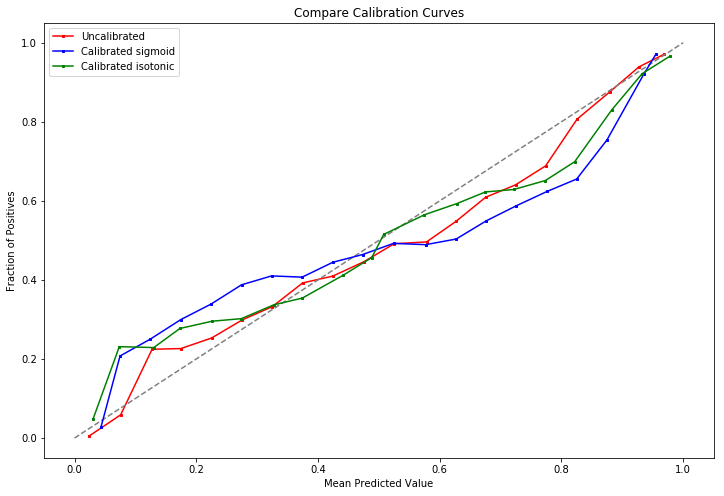

In [136]:
fig, ax = mplt.subplots(1,figsize=(12,8))

fraction_of_pos, mean_pred_val = calibration_curve(y_test, y_tst_proba, n_bins=20)
mplt.plot(mean_pred_val, fraction_of_pos, 's-', markersize=2, color='red', label='Uncalibrated')
mplt.plot([0,1],[0,1],'--',color='gray')

methodlst=['sigmoid','isotonic']
clr=['blue','green']
i=0
for method in methodlst:
    clf_calib=CalibratedClassifierCV(cl, cv='prefit', method=method)
    clf_calib.fit(X_train_meta, y_train)
    y_tst_clf_calib_proba=clf_calib.predict_proba(X_test_meta)[:,1]
    fraction_of_pos, mean_pred_val = calibration_curve(y_test, y_tst_clf_calib_proba, n_bins=20)
    mplt.plot(mean_pred_val, fraction_of_pos, 's-', markersize=2, color=clr[i], label='Calibrated %s' % method)
    i=i+1
    
mplt.xlabel('Mean Predicted Value')
mplt.ylabel('Fraction of Positives')
mplt.legend(loc='best')
mplt.title('Compare Calibration Curves')
mplt.show()
